## Importing libraries

In [1]:
import pandas as pd
from dotenv import load_dotenv
import os
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore") 

In [2]:
## load env
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
load_dotenv(os.path.join(BASE_DIR, '.env'))

True

## Retrieve client data

In [3]:
# find newly added and edited transactions
conn = pymysql.connect(host=os.getenv("MYSQL_DB_HOST") ,
                       port=3306,
                       user=os.getenv("MYSQL_DB_USER"),
                       passwd=os.getenv("MYSQL_DB_PASSWORD"),
                       db=os.getenv("MYSQL_DB_NAME"))

transaction data

In [4]:
trxn_df = pd.read_sql_query(("Select profileID,max(transactionDate) as lastTransactionDate,sum(transactionAmount) " 
                             "as monetaryValue, count(*) as frequency from transactions group by profileID"), con=conn)

client status data

In [5]:
client_status_df = pd.read_sql_query(("Select * from clients"), con=conn)

filter for only active clients

In [6]:
client_df = trxn_df.merge(client_status_df[["profileID"]],on="profileID")

In [7]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8785 entries, 0 to 8784
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   profileID            8785 non-null   object        
 1   lastTransactionDate  8785 non-null   datetime64[ns]
 2   monetaryValue        8785 non-null   float64       
 3   frequency            8785 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 274.7+ KB


## Calculate Recency values

In [8]:
# recency
client_df['recency'] = (datetime.now().date() - client_df['lastTransactionDate'].dt.date)

In [9]:
# extract days for recency
client_df.recency = client_df.recency.apply(lambda row:str(row).split("days")[0])
client_df.recency = client_df.recency.apply(lambda row:str(row).split("day")[0])

In [10]:
client_df.recency = client_df.recency.astype(int)

## Plotting RFM distributions

Recency

In [22]:
client_df.recency.max()

942

In [23]:
client_df.recency.min()

6

(array([3.998e+03, 7.990e+02, 5.330e+02, 4.410e+02, 3.440e+02, 2.418e+03,
        1.340e+02, 1.500e+01, 2.600e+01, 2.000e+01, 2.600e+01, 1.600e+01,
        1.100e+01, 2.000e+00, 2.000e+00]),
 array([  6. ,  68.4, 130.8, 193.2, 255.6, 318. , 380.4, 442.8, 505.2,
        567.6, 630. , 692.4, 754.8, 817.2, 879.6, 942. ]),
 <BarContainer object of 15 artists>)

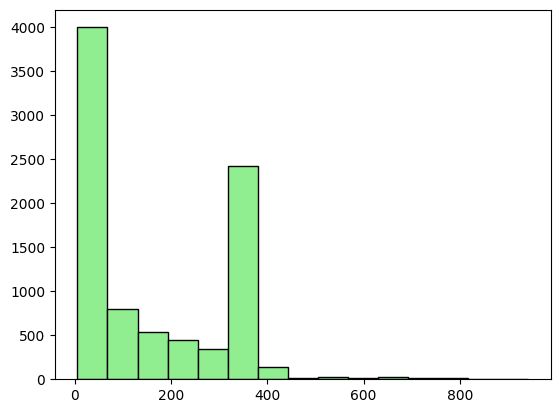

In [12]:
plt.hist(client_df.recency, color='lightgreen', ec='black', bins=15)

This plot shows that more than 4000 of the active client base have transacted in the last 50 days. Which is a little over half the client base. With the highest number of days being 942 days and the lowest being 6 days

Frequency

In [24]:
client_df.frequency.max()

6969

In [25]:
client_df.frequency.min()

1

(array([8.539e+03, 1.770e+02, 5.100e+01, 8.000e+00, 5.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00000000e+00, 4.65533333e+02, 9.30066667e+02, 1.39460000e+03,
        1.85913333e+03, 2.32366667e+03, 2.78820000e+03, 3.25273333e+03,
        3.71726667e+03, 4.18180000e+03, 4.64633333e+03, 5.11086667e+03,
        5.57540000e+03, 6.03993333e+03, 6.50446667e+03, 6.96900000e+03]),
 <BarContainer object of 15 artists>)

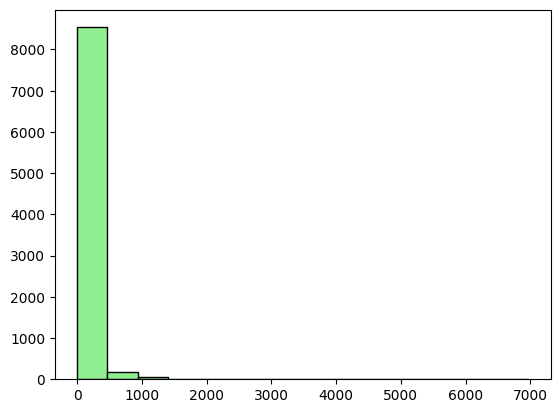

In [20]:
plt.hist(client_df.frequency, color='lightgreen', ec='black', bins=15)

This plot shows that almost all of the active client base have made less than 1000 transactions. With the highest being 6969 and the lowest being 1.

Monetary Value

In [26]:
client_df.monetaryValue.max()

24744051.28

In [27]:
client_df.monetaryValue.min()

0.67

(array([8.759e+03, 1.400e+01, 5.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00]),
 array([6.70000000e-01, 1.64960404e+06, 3.29920742e+06, 4.94881079e+06,
        6.59841417e+06, 8.24801754e+06, 9.89762091e+06, 1.15472243e+07,
        1.31968277e+07, 1.48464310e+07, 1.64960344e+07, 1.81456378e+07,
        1.97952412e+07, 2.14448445e+07, 2.30944479e+07, 2.47440513e+07]),
 <BarContainer object of 15 artists>)

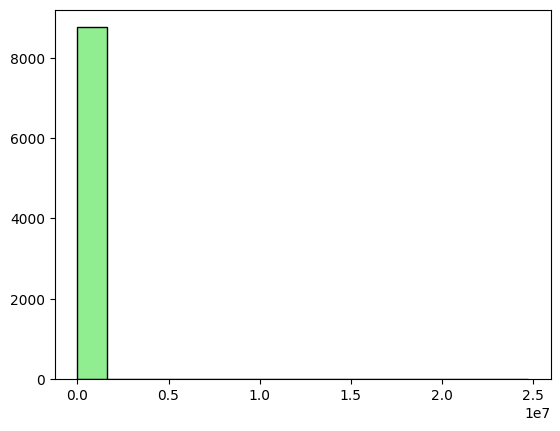

In [21]:
plt.hist(client_df.monetaryValue, color='lightgreen', ec='black', bins=15)

This plot shows that almost all of the active client base have a very low monetary value. With the highest being GHS 24744051.28 and the lowest being 67 pesewas.

## Calculate RFM scores

In [110]:
recency_scores = [5, 4, 3, 2, 1]  # Higher score for lower recency (more recent transactions)
frequency_scores = [1, 2, 3, 4, 5]  # Higher score for higher frequency
monetary_scores = [1, 2, 3, 4, 5]  # Higher score for higher monetary value

# Calculate RFM scores
client_df['recencyScore'] = pd.cut(client_df['recency'], bins=5, labels=recency_scores)
client_df['frequencyScore'] = pd.cut(client_df['frequency'], bins=5, labels=frequency_scores)
client_df['monetaryScore'] = pd.cut(client_df['monetaryValue'], bins=5, labels=monetary_scores)

In [111]:
client_df['recencyScore'] = client_df['recencyScore'].astype(int)
client_df['frequencyScore'] = client_df['frequencyScore'].astype(int)
client_df['monetaryScore'] = client_df['monetaryScore'].astype(int)

## RFM value segmentation

In [112]:
# calc RFM score
client_df['rfmScore'] = client_df['recencyScore'] + client_df['frequencyScore'] + client_df['monetaryScore']

In [113]:
# Create RFM segments based on the RFM score
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
client_df['valueSegment'] = pd.qcut(client_df['rfmScore'], q=3, labels=segment_labels)

Segment distribution

In [114]:
segment_counts = client_df['valueSegment'].value_counts().reset_index()

In [115]:
segment_counts

,valueSegment,count
0,Mid-Value,5313
1,Low-Value,3452
2,High-Value,20


bar chart

In [116]:
fig = plt.figure(figsize = (10, 5))

<Figure size 1000x500 with 0 Axes>

In [117]:
segments = list(segment_counts["valueSegment"].unique())
segment_values = list(segment_counts["count"].unique())

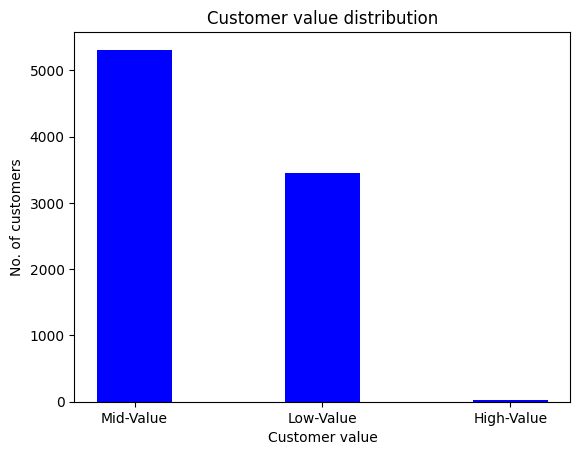

In [118]:
plt.bar(segments, segment_values, color ='blue',
        width = 0.4)
plt.xlabel("Customer value")
plt.ylabel("No. of customers")
plt.title("Customer value distribution")
plt.show()

## RFM Customer Segmentation

In [119]:
# Assign RFM segments based on the RFM score
client_df.loc[client_df['rfmScore'] >= 9, 'RFMCustomerSegments'] = 'Champions'
client_df.loc[(client_df['rfmScore'] >= 6) & (client_df['rfmScore'] < 9), 'RFMCustomerSegments'] = 'Potential Loyalists'
client_df.loc[(client_df['rfmScore'] >= 5) & (client_df['rfmScore'] < 6), 'RFMCustomerSegments'] = 'Promising'
client_df.loc[(client_df['rfmScore'] >= 4) & (client_df['rfmScore'] < 5), 'RFMCustomerSegments'] = "Needs Attention"
client_df.loc[(client_df['rfmScore'] >= 3) & (client_df['rfmScore'] < 4), 'RFMCustomerSegments'] = "Lost"

value and customer segment distribution

In [120]:
segment_product_counts = client_df.groupby(['valueSegment', 'RFMCustomerSegments']).size().reset_index(name='Count')

In [121]:
segment_product_counts = segment_product_counts.sort_values('Count', ascending=False)

In [130]:
segment_product_counts

,valueSegment,RFMCustomerSegments,Count
8,Mid-Value,Potential Loyalists,5313
3,Low-Value,Potential Loyalists,3201
4,Low-Value,Promising,174
2,Low-Value,Needs Attention,62
1,Low-Value,Lost,15
13,High-Value,Potential Loyalists,12
10,High-Value,Champions,8
0,Low-Value,Champions,0
5,Mid-Value,Champions,0
6,Mid-Value,Lost,0


In [ ]:
# 20 september 2023